Тут ми спробуємо провести кластеризацію текстів ПІСЛЯ зменшення словника

In [1]:
import pandas as pd
import numpy as np
from requests_finder import load_request, contains_mention
import re

# Load data. Choose random 5000 rows

In [2]:
df_tags = pd.read_excel("home_appliances_with_tags.xlsx", index_col=0)
print(f"Loaded {df_tags.shape[0]} rows")

df_rus = pd.read_excel("home_appliances_rus_reduced.xlsx", index_col=0)
print(f"Loaded {df_rus.shape[0]} rows")

Loaded 6802 rows
Loaded 6802 rows


In [3]:
df_tags.head(1)

,title,text,source_type,source,date,home_appliances,MAIN_1: НЕРЕЛЕВАНТ,MAIN_1: Продаж нової техніки,MAIN_1: Продаж Б/У,MAIN_1: Ремонт/Поломки/Деталі,...,MAIN_2: Морозильна камера,MAIN_2: Духовка,MAIN_2: Варочні поверхні,MAIN_2: Витяжка,MAIN_2: Мікрохвильовка,MAIN_2: Кондиціонер,MAIN_2: Пилосос,MAIN_2: Бойлер,clean_text,lang
0,Инверторные кондиционеры | Купить в Москве по ...,<p>Инверторные кондиционеры | Купить в Москве ...,Социальные сети,facebook,2022-01-20 15:53:00,True,False,True,False,False,...,False,False,False,False,False,True,False,False,инверторные кондиционеры купить в москве по вы...,ru


In [4]:
df_rus.head(1)

,mention,clean_text,language,clipped_part_correct,translated_text,clean_rus,clean_rus_no_stopwords,index,lemmatized,lemmatized_with_pos,lemmatized_with_vectors_and_pos,reduced_with_pos,reduced_no_pos
0,Инверторные кондиционеры | Купить в Москве по ...,инверторные кондиционеры | купить в москве по ...,ru,NaN,инверторные кондиционеры | купить в москве по ...,инверторные кондиционеры купить в москве по вы...,инверторные кондиционеры купить москве выгодно...,0,инверторный кондиционер покупать москве выгодн...,инверторный_ADJ кондиционер_NOUN покупать_VERB...,кондиционер_NOUN покупать_VERB москве_NOUN выг...,кондиционер_NOUN купить_VERB москве_NOUN выгод...,кондиционер купить москве выгодный расценка ус...


In [5]:
lemmatized = {}

for index in df_rus.index:
    lemmatized[index] = df_rus.loc[index, "reduced_no_pos"].split(" ")

In [6]:
df_tags.drop(columns=['title', 'text', 'source_type', 'source', 
                      'date', 'home_appliances', 'clean_text', 'lang'], inplace=True)

In [7]:
all_tags = list(df_tags.columns)
tag2id = {tag:i for i, tag in enumerate(all_tags)}
id2tag = {i:tag for tag, i in tag2id.items()}

### Create vocabulary and replace tokens with ids

In [8]:
vocab = []
for tokens in lemmatized.values():
    for word in tokens:
        if word not in vocab:
            vocab.append(word)

print(len(vocab))

7113


In [9]:
word2ind = {}
ind2word = {}
n = 0
for word in vocab:
    word2ind[word] = n
    ind2word[n] = word
    n += 1

In [10]:
lemmatized_w_ids = {}
for key, tokens in lemmatized.items():
    new_tokens = []
    for word in tokens:
        new_tokens.append(word2ind[word])
    lemmatized_w_ids[key] = new_tokens

# Analyze words

In [11]:
ids_frequencies = {}

for key, words in lemmatized_w_ids.items():
    for word in words:
        if word in ids_frequencies.keys():
            ids_frequencies[word] += 1
        else:
            ids_frequencies[word] = 1


ids_frequencies = {k: v for k, v in sorted(ids_frequencies.items(), key=lambda item: item[1], reverse=True)}

words_frequency = {ind2word[k]: v for k, v in ids_frequencies.items()}

In [12]:
list(words_frequency.items())[:5]

[('машина', 6032),
 ('стиральный', 5703),
 ('холодильник', 4430),
 ('расценка', 4184),
 ('samsung', 3224)]

In [13]:
# lets remove russian names

russian_names = pd.read_csv("russian_names.csv", sep=';')
russian_names.drop(columns=['ID', 'Sex', 'PeoplesCount', 'WhenPeoplesCount', 'Source'], inplace=True)
print("Loaded", russian_names.shape[0], "unique russian names")

Loaded 51529 unique russian names


In [14]:
popped_ids = []
popped_words = []

popped_names = 0
for name in russian_names.Name.values:
    if name.lower() in words_frequency.keys():
#         print(name)
        words_frequency.pop(name.lower())
        index = word2ind[name.lower()]
        ids_frequencies.pop(index)
        
        popped_names += 1
        popped_ids.append(index)
        popped_words.append(name.lower())
        
print(f"Popped {popped_names} names")

Popped 366 names


In [15]:
# lets count number of rare words
n_rare_words = len([k for k, v in words_frequency.items() if v == 1])
print(f"Total of {n_rare_words} words that were encountered only 1 time per whole corpus")

Total of 1844 words that were encountered only 1 time per whole corpus


In [16]:
# drop rare words
for k, v in list(words_frequency.items()):
    if v == 1:
        words_frequency.pop(k)
        ids_frequencies.pop(word2ind[k])
        
        popped_ids.append(word2ind[k])
        popped_words.append(k)

In [17]:
print(len(words_frequency))

4903


In [18]:
vocab_new = [w for w in vocab if w not in popped_words]

In [19]:
word2ind_new = {}
ind2word_new = {}
n = 0
for word in vocab_new:
    word2ind_new[word] = n
    ind2word_new[n] = word
    n += 1

In [20]:
lemmatized_w_ids = {}
for key, tokens in lemmatized.items():
    new_tokens = []
    for word in tokens:
        try:
            index = word2ind_new[word]
        except:
            continue
        else:
            new_tokens.append(index)
    lemmatized_w_ids[key] = new_tokens

In [21]:
lemmatized_cutted = {}
empty_sentences = 0 
for key, tokens_ids in lemmatized_w_ids.items():
    lemmatized_cutted[key] = [ind2word_new[token_id] for token_id in tokens_ids]
    if len(lemmatized_cutted[key]) == 0:
        empty_sentences += 1
        
df_rus["lemmatized_cutted"] = [" ".join(value) for value in lemmatized_cutted.values()]

print(f"Number of empty sentences is {empty_sentences}")

Number of empty sentences is 0


In [22]:
df_rus.tail(1)

,mention,clean_text,language,clipped_part_correct,translated_text,clean_rus,clean_rus_no_stopwords,index,lemmatized,lemmatized_with_pos,lemmatized_with_vectors_and_pos,reduced_with_pos,reduced_no_pos,lemmatized_cutted
31880,"Продается дом махалля Октепа , 3 сот.земли,4 к...","продается дом махалля октепа , сот . земли , к...",ru,NaN,"продается дом махалля октепа , сот . земли , к...",продается дом махалля октепа сот земли комн ку...,продается дом махалля октепа сот земли комн ку...,31880,продаваться дом махалля октепый сот земля комн...,продаваться_VERB дом_NOUN махалля_NOUN октепый...,продаваться_VERB дом_NOUN сот_NOUN земля_NOUN ...,продавать_VERB дом_NOUN десяток_NOUN камень_NO...,продавать дом десяток камень комната гостиная ...,продавать десяток камень комната гостиная прин...


# ~ LSA ~

Lets create mapper from old index in the df to the new one

In [23]:
old2new_index = {}
new2old_index = {}
n = 0
for key in lemmatized_w_ids.keys():
    old2new_index[key] = n
    new2old_index[n] = key
    n += 1

In [24]:
#  lets create vectors for our texts
D = len(vocab_new)
N = len(lemmatized_cutted.keys())

one_hot_encoding = np.zeros((N, D))
for key, tokens_ids in lemmatized_w_ids.items():
#     print(key)
    for token_id in tokens_ids:
        one_hot_encoding[old2new_index[key], token_id] += 1

# PCA

In [25]:
from sklearn.decomposition import FactorAnalysis, FastICA, IncrementalPCA
# from sklearn.
import matplotlib.pyplot as plt

In [26]:
# %matplotlib notebook

Подивимось зменшимо розмірність до 5000-вимірного простору та поглянемо на оптимальну к-сть просторів

In [27]:
%%time
pca = IncrementalPCA(n_components=2000)
Z = pca.fit_transform(one_hot_encoding)

Wall time: 51.2 s


In [28]:
print(f"Explained variance -- {pca.explained_variance_ratio_.sum()}")

Explained variance -- 0.9862723937955475


In [29]:
s = 0
for i, x in enumerate(pca.explained_variance_ratio_):
    s += x
    if s >= 0.9:
        break

print(f"90% of the variance is explained with n_components={i+1}")
optimal_n = i + 1
del i, s, x

90% of the variance is explained with n_components=742


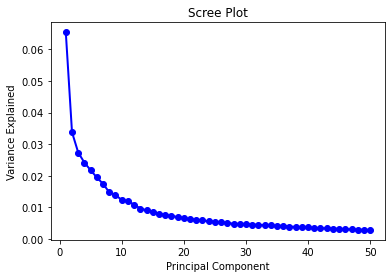

In [30]:
N = 50
PC_values = np.arange(pca.n_components_) + 1
PC_values = PC_values[:N]
plt.plot(PC_values, pca.explained_variance_ratio_[:N], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

На мою думку, приблизно після 15-ї компоненти наростання описаної варіаціїї не є таким стрімким.
Отже, спробуємо такі варіанти:
1. n = 3
2. n = 15
3. n = 742

#### N = 3

In [31]:
%%time
Z = IncrementalPCA(n_components=3).fit_transform(one_hot_encoding)

Wall time: 50.7 s


In [32]:
%matplotlib notebook

plot all points

<IPython.core.display.Javascript object>


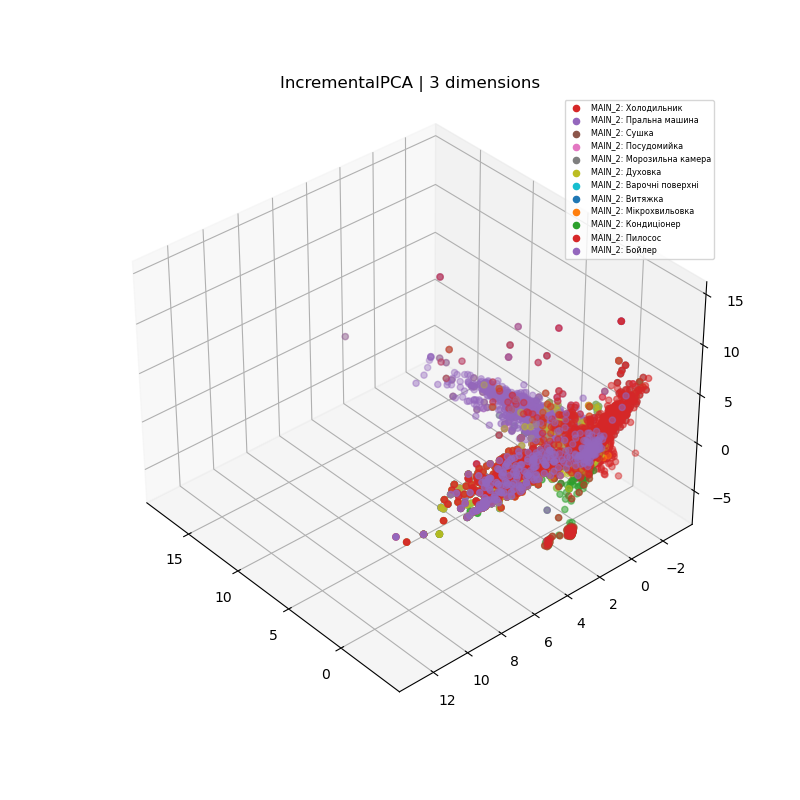

In [33]:
dims = (0, 1, 2)
# must be MAIN_1 or MAIN_2
tag_type = "MAIN_2"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for tag_name in df_tags.columns:
    if tag_type not in tag_name:
        continue
    
    indexes_old = df_tags[df_tags[tag_name]].index
    indexes_new = [old2new_index[i] for i in indexes_old]
    
    Z_temp = Z[indexes_new]
    ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
               c=f"C{tag2id[tag_name]}", label=tag_name)

plt.title('IncrementalPCA | 3 dimensions')
plt.legend(loc="best", fontsize="xx-small")
plt.show()

plot points by the tag

In [43]:
def plot_points_by_tag_set(Z, tag_type, dims=(0, 1, 2)):
    # must be MAIN_1 or MAIN_2
    assert tag_type in ["MAIN_1", "MAIN_2"]
    
    curr_tags = [tag for tag in all_tags if tag_type in tag]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(curr_tags)))

    nrows = len(curr_tags) // 2 + 1
    ncols = 2

    for i, tag_name in enumerate(curr_tags):
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(projection='3d')

        color = colors[i]

        nrow = i // 2
        ncol = i % 2

        indexes_old = df_tags[df_tags[tag_name]].index
        indexes_new = [old2new_index[i] for i in indexes_old]

        Z_temp = Z[indexes_new]
        ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
                   color=color, label=tag_name, marker="o")

        Z_temp = Z[[i for i in range(len(Z)) if i not in indexes_new]]
        ax.scatter(Z_temp[:, dims[0]], Z_temp[:, dims[1]], Z_temp[:, dims[2]], 
                   color="black", marker=".", alpha=0.05, label="Other texts")

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")

        plt.rcParams['grid.linewidth'] = 0.1

        plt.title(tag_name)
        plt.legend(loc="best", fontsize="xx-small")
        plt.show()

<IPython.core.display.Javascript object>


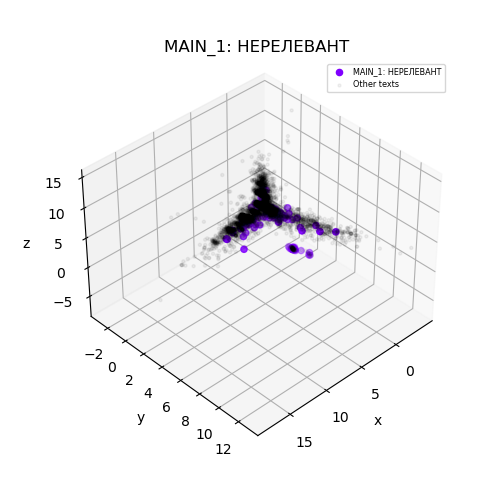

<IPython.core.display.Javascript object>


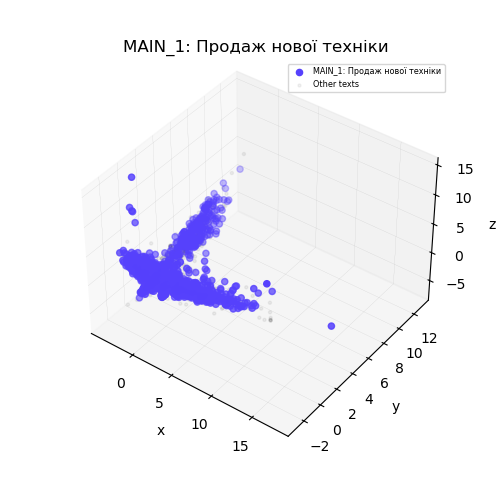

<IPython.core.display.Javascript object>


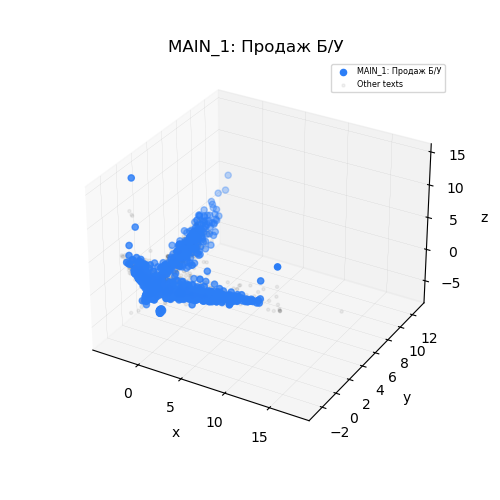

<IPython.core.display.Javascript object>


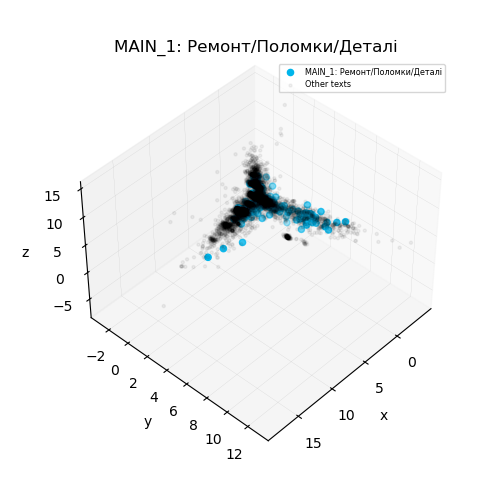

<IPython.core.display.Javascript object>


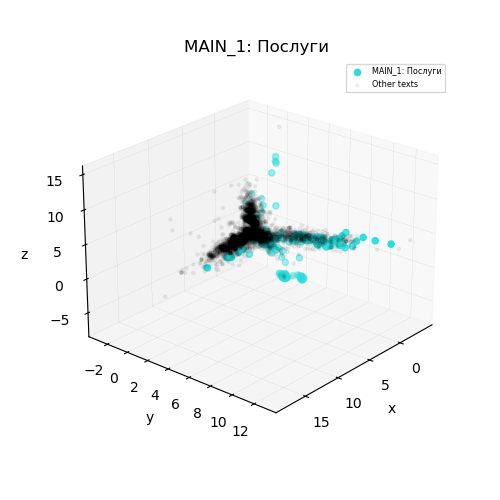

<IPython.core.display.Javascript object>


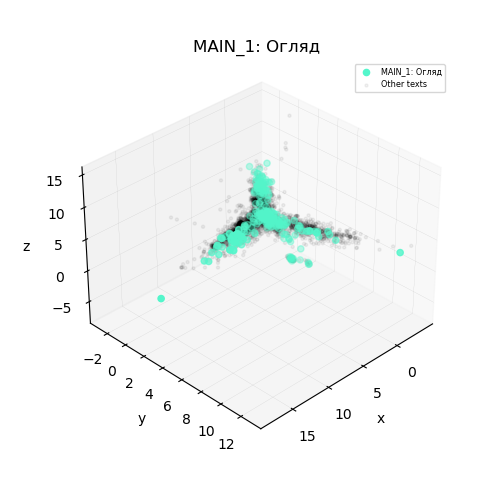

<IPython.core.display.Javascript object>


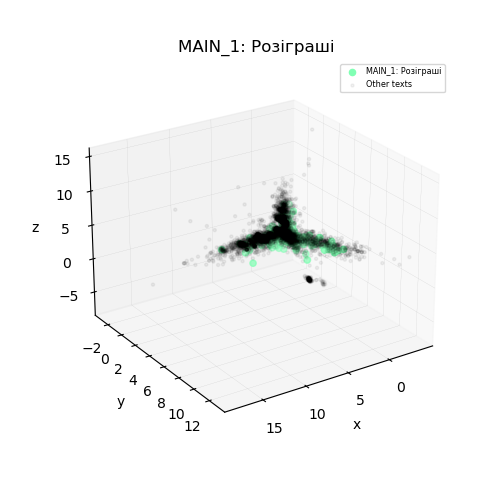

<IPython.core.display.Javascript object>


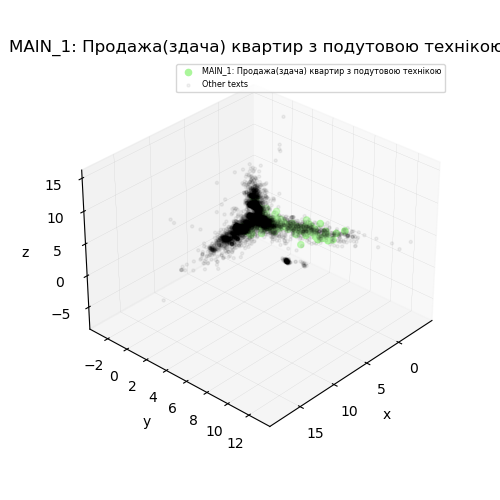

<IPython.core.display.Javascript object>


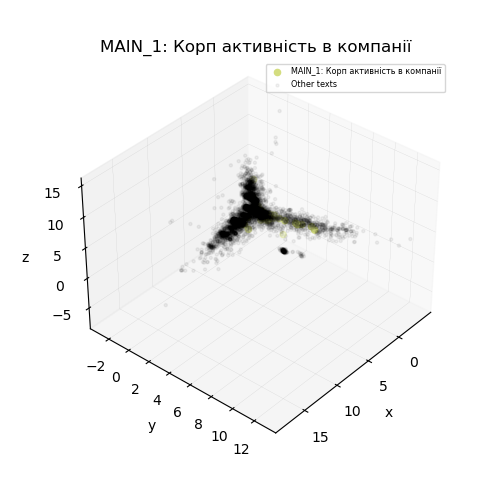

<IPython.core.display.Javascript object>


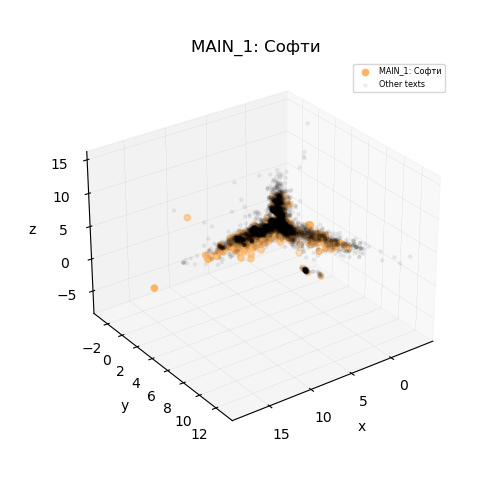

<IPython.core.display.Javascript object>


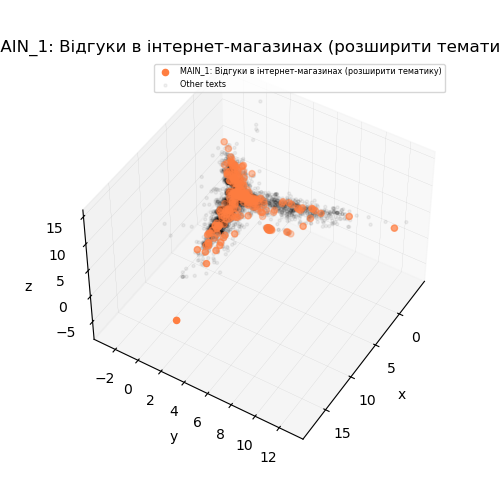

<IPython.core.display.Javascript object>


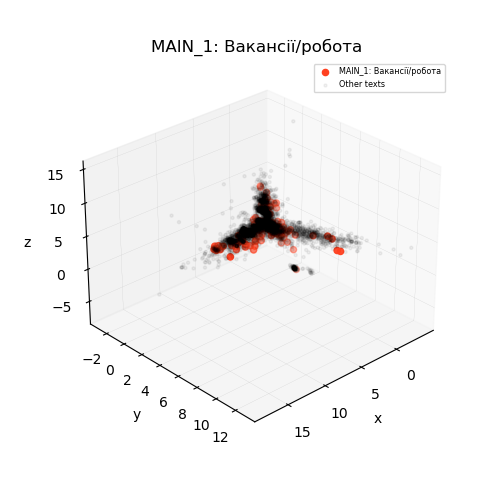

<IPython.core.display.Javascript object>


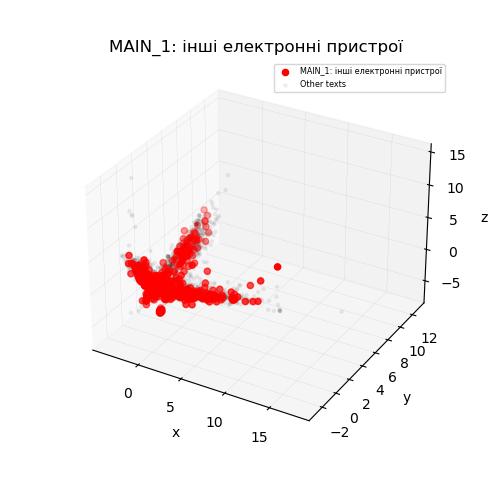

In [35]:
plot_points_by_tag_set(Z, "MAIN_1")

<IPython.core.display.Javascript object>


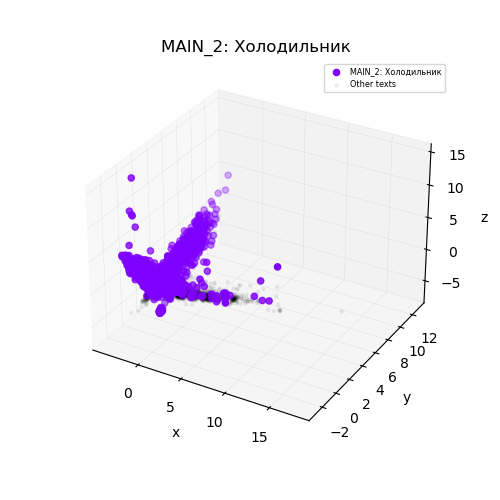

<IPython.core.display.Javascript object>


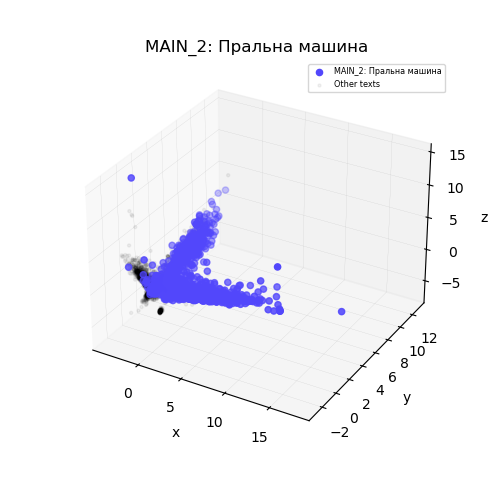

<IPython.core.display.Javascript object>


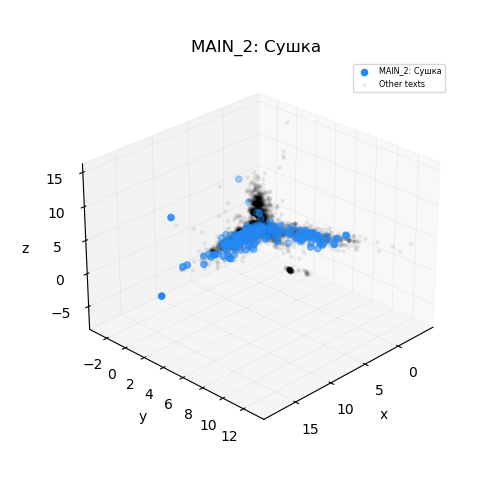

<IPython.core.display.Javascript object>


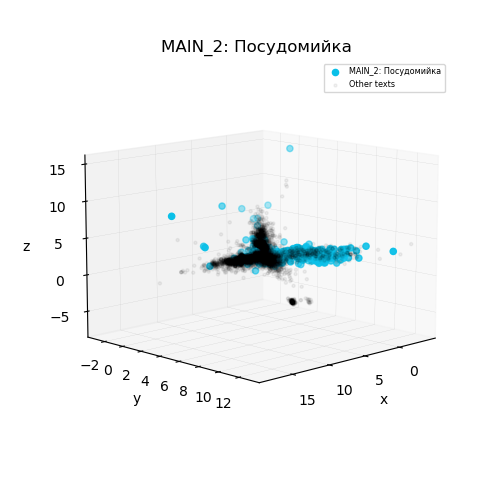

<IPython.core.display.Javascript object>


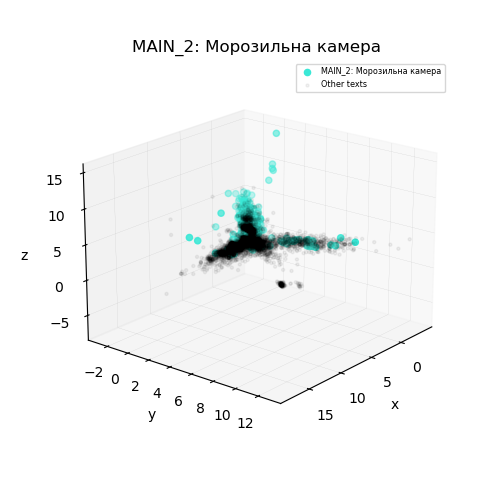

<IPython.core.display.Javascript object>


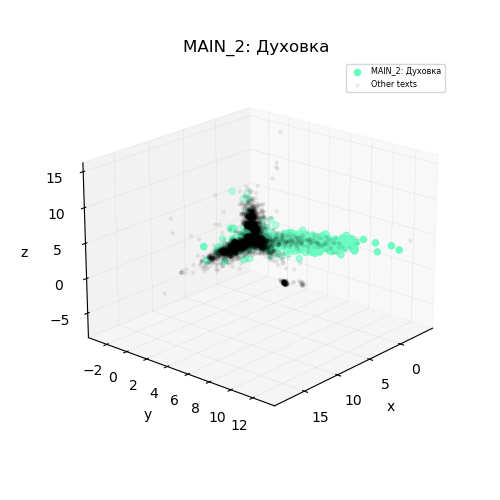

<ipython-input-34-f66d642be258>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5, 5))


<IPython.core.display.Javascript object>


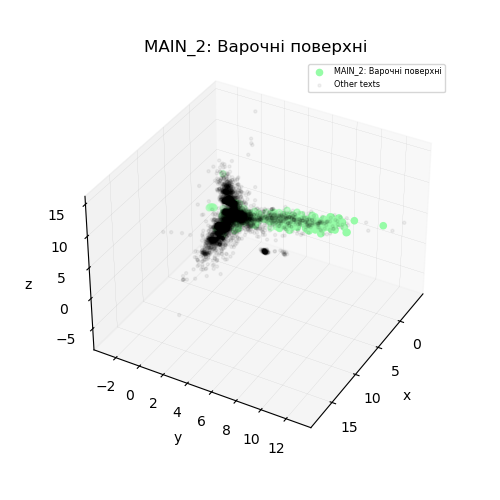

<IPython.core.display.Javascript object>


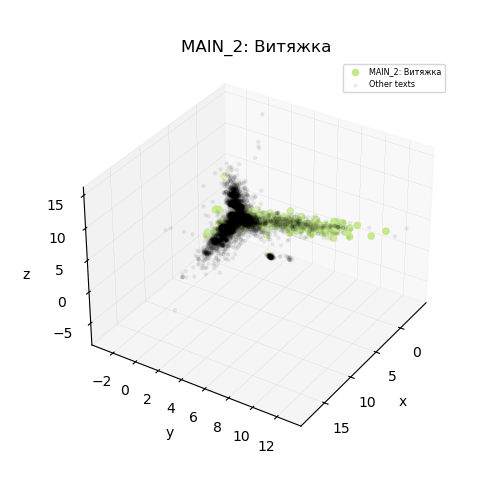

<IPython.core.display.Javascript object>


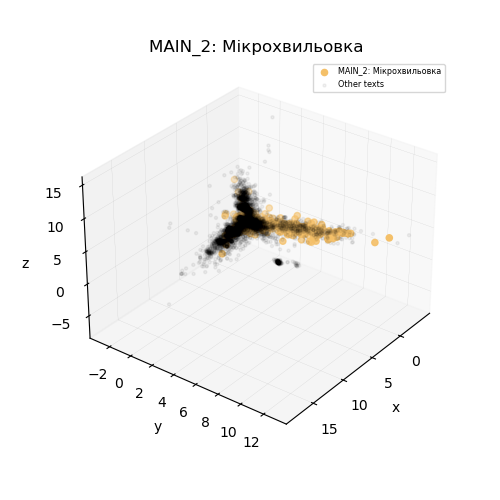

<IPython.core.display.Javascript object>


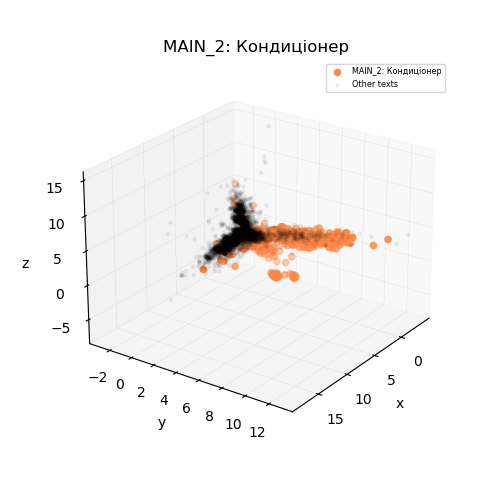

<IPython.core.display.Javascript object>


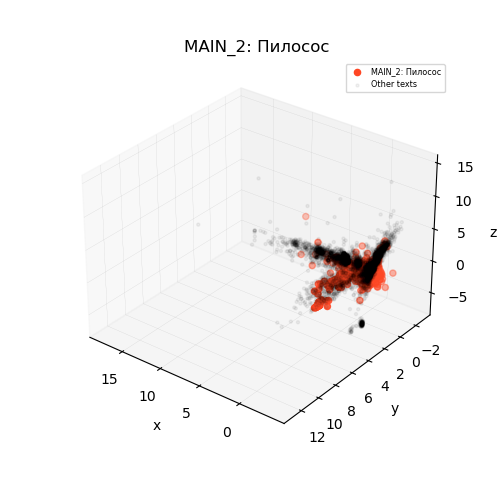

<IPython.core.display.Javascript object>


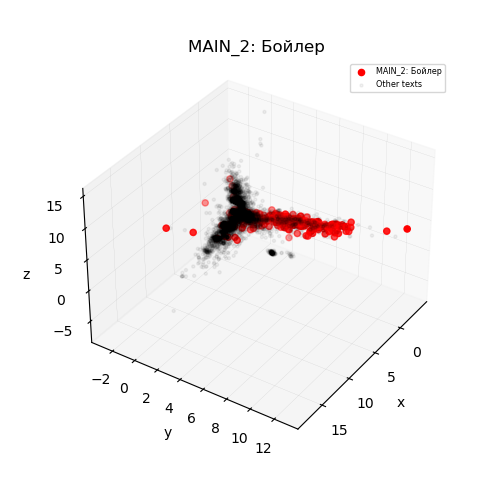

In [36]:
plot_points_by_tag_set(Z, "MAIN_2")